In [2]:
import math
from typing import Callable

import dataframe_image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay

from score_analysis import BootstrapConfig, ConfusionMatrix, utils
from score_analysis.experimental import BernoulliDataset, CorrelatedBernoullilDataset

matplotlib.rcParams.update({"errorbar.capsize": 3})

## Helper functions

In [3]:
def cm_to_pandas(
    cm: ConfusionMatrix,
    *,
    label_name: str = "Label",
    prediction_name: str = "Prediction",
) -> pd.DataFrame:
    """Convert confidence matrix to dataframe for nicer presentation."""
    df = pd.DataFrame(data=cm.matrix, index=cm.classes, columns=cm.classes)
    df.index.name = label_name
    df.columns.name = prediction_name
    return df

In [9]:
# We reuse most of the BootstrapConfig from score_analysis, but we need to change
# the default sampling method.
DEFAULT_BOOTSTRAP_CONFIG = BootstrapConfig(sampling_method="joint")


def bootstrap_ci(
    data: np.ndarray,
    metric: Callable,
    alpha: float = 0.05,
    config: BootstrapConfig = DEFAULT_BOOTSTRAP_CONFIG,
    **kwargs,
) -> np.ndarray:
    """
    We bootstrap CIs for a metric, which is a function of data.

    Args:
        data: An array of shape (m, n), where we assume that we have `m` measurements
            on `n` data points. We also support shape (n,), which is treated as (1, n).
        metric: A function with signature metric(data, **kwargs).
        alpha: Significance level.
        config: Bootstrap config.
        **kwargs: Parameters to be passed to the metric.

    Returns:
        CI of shape (2, X), where (X,) is the shape returned by `metric`.
    """
    one_dim = data.ndim == 1
    n = data.shape[-1]

    m_hat = np.asarray(metric(data, **kwargs))
    if one_dim:  # Independent sampling wants a 2d array
        data = data[np.newaxis]
    metric_samples = np.empty(
        shape=(config.nb_samples, *m_hat.shape), dtype=m_hat.dtype
    )

    for j in range(config.nb_samples):
        if config.sampling_method == "joint":
            idx = np.random.choice(n, size=n, replace=True)
            sample = data[..., idx]
        elif config.sampling_method == "independent":
            sample = np.empty_like(data)
            for k in range(len(data)):  # We sample each row independently
                sample[k] = np.random.choice(data[k], size=n, replace=True)
        else:
            raise ValueError("Unknown sampling method.")
        if one_dim:
            sample = sample[0]  # Metric might expect 1d input
        metric_samples[j] = metric(sample, **kwargs)

    ci = utils.bootstrap_ci(
        theta=metric_samples,
        theta_hat=m_hat,
        alpha=alpha,
        method=config.bootstrap_method,
    )
    return ci

In [11]:
def accuracy(data):
    return data.mean()


def accuracy_delta(data):
    return data[1].mean() - data[0].mean()

In [12]:
def print_ci(label: str, value: float, ci: np.ndarray, alpha: float = 0.05):
    alpha = 1 - alpha
    print(f"{label}: {value:.2%}, {alpha:.0%}-CI ({ci[0]:.2%}, {ci[1]:.2%})")

In [13]:
def print_ci_test(label: str, ci: np.ndarray):
    significant = ci[1] < 0 or ci[0] > 0
    marker = "🟢" if significant else ""
    print(f"{label}: ({ci[0]:.2%}, {ci[1]:.2%}) {marker}")

## Synthetic example

In [14]:
generator = CorrelatedBernoullilDataset(p1=0.96, p2=0.98, rho=0.0)
data = generator.sample(n=2000, random=False)
cm = ConfusionMatrix(labels=data[0], predictions=data[1])

In [15]:
cm_to_pandas(cm, label_name="Baseline", prediction_name="Experiment")

Experiment,0,1
Baseline,,
0,1,78
1,38,1883


In [16]:
base_ci = bootstrap_ci(data[0], accuracy)
exp_ci = bootstrap_ci(data[1], accuracy)

In [17]:
print_ci("Baseline", accuracy(data[0]), base_ci)
print_ci("Experiment", accuracy(data[1]), exp_ci)

Baseline: 96.05%, 95%-CI (95.30%, 96.90%)
Experiment: 98.05%, 95%-CI (97.45%, 98.65%)


In [18]:
indep_ci = bootstrap_ci(
    data, accuracy_delta, config=BootstrapConfig(sampling_method="independent")
)
joint_ci = bootstrap_ci(
    data, accuracy_delta, config=BootstrapConfig(sampling_method="joint")
)

In [19]:
print("Accuracy of experiment - baseline")
print_ci_test("Independent sampling", indep_ci)
print_ci_test("Joint sampling", joint_ci)

Accuracy of experiment - baseline
Independent sampling: (0.95%, 3.05%) 🟢
Joint sampling: (1.00%, 3.10%) 🟢


### Adding a shared component

In [20]:
# We simulate the effect of another component in the system, which has 80% accuracy.
# So 20% of the data is treated as incorrectly predicted. This component is shared
# across the two classifiers.
zero_idx = np.random.binomial(n=1, p=0.2, size=data.shape[1])
zero_idx = zero_idx.astype(bool)
data_2 = data.copy()
data_2[:, zero_idx] = 0
cm_2 = ConfusionMatrix(labels=data_2[0], predictions=data_2[1])

In [21]:
cm_to_pandas(cm_2, label_name="Baseline", prediction_name="Experiment")

Experiment,0,1
Baseline,,
0,402,66
1,33,1499


In [22]:
np.corrcoef(data_2)

array([[1.        , 0.85941126],
       [0.85941126, 1.        ]])

In [23]:
base_ci = bootstrap_ci(data_2[0], accuracy)
exp_ci = bootstrap_ci(data_2[1], accuracy)

In [24]:
print_ci("Baseline", accuracy(data_2[0]), base_ci)
print_ci("Experiment", accuracy(data_2[1]), exp_ci)

Baseline: 76.60%, 95%-CI (74.75%, 78.48%)
Experiment: 78.25%, 95%-CI (76.40%, 79.90%)


In [25]:
indep_ci = bootstrap_ci(
    data_2, accuracy_delta, config=BootstrapConfig(sampling_method="independent")
)
joint_ci = bootstrap_ci(
    data_2, accuracy_delta, config=BootstrapConfig(sampling_method="joint")
)

In [26]:
print("Accuracy of experiment - baseline")
print_ci_test("Independent sampling", indep_ci)
print_ci_test("Joint sampling", joint_ci)

Accuracy of experiment - baseline
Independent sampling: (-1.20%, 4.20%) 
Joint sampling: (0.70%, 2.56%) 🟢


## Width of confidence intervals

In [27]:
err_list = [0.01, 0.03, 0.1]
support_list = [3, 10, 30, 100, 300]
alpha = 0.05

ci = np.empty((len(err_list), len(support_list), 2))
for j, err in enumerate(err_list):
    for k, support in enumerate(support_list):
        n = math.ceil(support / err)
        data = BernoulliDataset(p=err).sample(n=n, random=False)
        ci[j, k] = bootstrap_ci(
            data=data,
            metric=lambda d: d.mean(),
            alpha=alpha,
        )

In [28]:
def plot_ci_support(err_list, support_list, ci, log_scale, filename=None):
    plt.figure(figsize=(5, 4))

    for j, err in enumerate(err_list):
        plt.errorbar(
            x=np.arange(len(support_list)) + 0.1 * j,
            y=[err] * len(support_list),
            yerr=[err - ci[j, :, 0], ci[j, :, 1] - err],
            fmt=".",
            label=f"Error rate={err:.0%}",
        )

    plt.xticks(ticks=range(len(support_list)), labels=support_list)
    if log_scale:
        plt.yscale("log")
        plt.ylim([3e-3, 6e-1])
    else:
        plt.ylim([-0.005, 0.21])
        err_list = [0] + err_list + [0.2]
    plt.yticks(ticks=err_list, labels=err_list)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    plt.grid("major")
    plt.xlabel("Support of error rate in dataset")
    plt.ylabel("Error rate")
    plt.legend(loc="upper right")
    plt.title("CI for error rate" + (" (log scale)" if log_scale else ""))
    if filename is not None:
        plt.savefig(filename)
    plt.show()

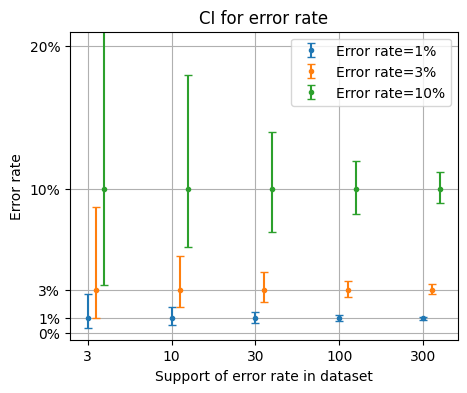

In [29]:
plot_ci_support(err_list, support_list, ci, log_scale=False, filename="ci_width.png")

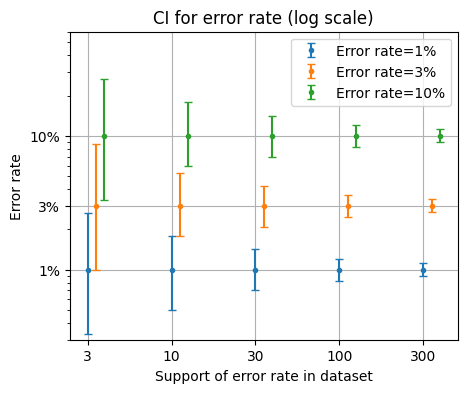

In [30]:
plot_ci_support(err_list, support_list, ci, log_scale=True, filename="ci_width_log.png")

## Sklearn correlated classifiers

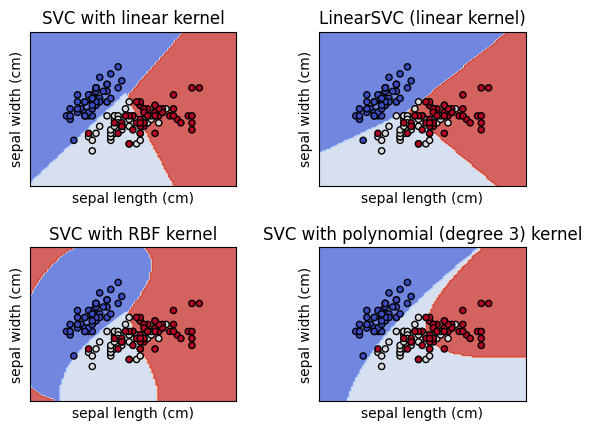

In [31]:
# SVMs trained on the Iris dataset. Example from the sklearn documentation
# https://scikit-learn.org/1.5/auto_examples/svm/plot_iris_svc.html

iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# We create an instance of SVM and fit out data. We do not scale our data
# since we want to plot the support vectors.
C = 1.0  # SVM regularization parameter
models = [
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
]
models = [clf.fit(X, y) for clf in models]

titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.savefig("iris_decision_boundary.png")
plt.show()

In [32]:
names = ["Linear SVM", "LinearSVC", "SVC with RBF", "SVC with poly(3)"]

# (4, N) matrix, whether model predicted a sample correctly or not.
correct = np.stack([clf.predict(X) == y for clf in models], axis=0)
correlation = np.corrcoef(correct)

df = pd.DataFrame(correlation, index=names, columns=names)
df["Accuracy"] = correct.mean(axis=-1)

formatter = {name: "{:.2f}" for name in names}
formatter["Accuracy"] = "{:.0%}"
df = df.style.format(formatter=formatter)
dataframe_image.export(df, "iris_correlation.png", dpi=300)

df

,Linear SVM,LinearSVC,SVC with RBF,SVC with poly(3),Accuracy
Linear SVM,1.00,0.68,0.93,0.98,82%
LinearSVC,0.68,1.00,0.74,0.66,80%
SVC with RBF,0.93,0.74,1.00,0.91,83%
SVC with poly(3),0.98,0.66,0.91,1.00,81%


## Joint vs independent CI size

In [33]:
p1 = 0.75
p2 = 0.78
n = 1_000


def _accuracy_delta(_data):
    return _data[1].mean() - _data[0].mean()


sampling_method_list = ["independent", "joint"]
rho_list = np.linspace(0.0, 0.9, 91, endpoint=True)
ci = np.empty((len(sampling_method_list), len(rho_list), 2))

for j, sampling_method in enumerate(sampling_method_list):
    for k, rho in enumerate(rho_list):
        generator = CorrelatedBernoullilDataset(p1=p1, p2=p2, rho=rho)
        data = generator.sample(n=n, random=False)
        ci[j, k] = bootstrap_ci(
            data,
            _accuracy_delta,
            config=BootstrapConfig(sampling_method=sampling_method),
        )

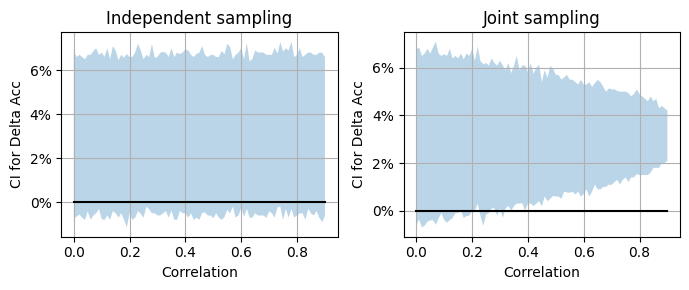

In [34]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.fill_between(rho_list, ci[0, :, 0], ci[0, :, 1], alpha=0.3)
plt.plot([min(rho_list), max(rho_list)], [0.0, 0.0], "k-")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.xlabel("Correlation")
plt.ylabel("CI for Delta Acc")
plt.title("Independent sampling")
plt.grid()

plt.subplot(1, 2, 2)
plt.fill_between(rho_list, ci[1, :, 0], ci[1, :, 1], alpha=0.3)
plt.plot([min(rho_list), max(rho_list)], [0.0, 0.0], "k-")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.xlabel("Correlation")
plt.ylabel("CI for Delta Acc")
plt.title("Joint sampling")
plt.grid()

plt.tight_layout()
plt.savefig("joint_vs_independent_sampling.png")
plt.show()

## Minimal detectable change

In [35]:
def detect_minimal_change(
    n: int, p: float, rho: float, sampling_method: str
) -> float | None:
    delta_p_inc = 0.001
    delta_p = 0.0

    def _accuracy_delta(_data):
        return _data[1].mean() - _data[0].mean()

    while p + delta_p <= 1.0:
        try:
            generator = CorrelatedBernoullilDataset(p1=p, p2=p + delta_p, rho=rho)
            data = generator.sample(n=n, random=False)
        # Some parameter combinations are not possible to be generated
        except ValueError:
            return np.nan

        ci = bootstrap_ci(
            data,
            _accuracy_delta,
            config=BootstrapConfig(sampling_method=sampling_method),
        )
        if ci[0] > 0.0:
            return delta_p
        delta_p += delta_p_inc

    return 1.0 - p  # Maximal possible change, could also throw error...

In [36]:
n = 1_000

sampling_method_list = ["joint", "independent"]
p_list = [0.6, 0.7, 0.8, 0.9]
rho_list = np.linspace(0.7, 0.95, 26, endpoint=True)
delta_p = dict()

for sampling_method in sampling_method_list:
    for p in p_list:
        for rho in rho_list:
            delta_p[sampling_method, p, rho] = detect_minimal_change(
                n=n, p=p, rho=rho, sampling_method=sampling_method
            )

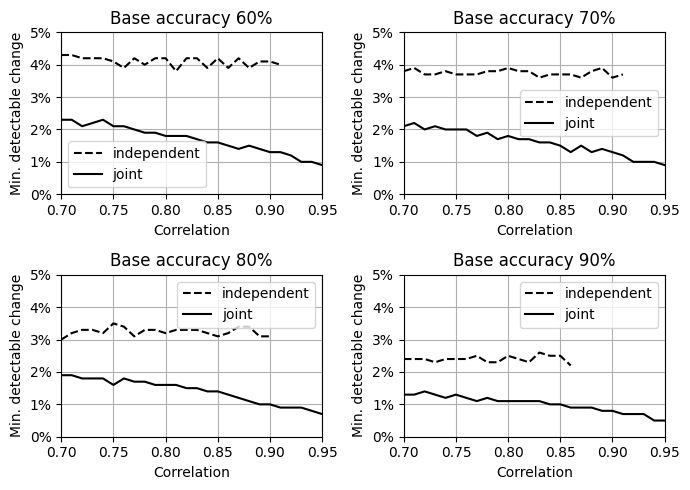

In [37]:
plt.figure(figsize=(7, 5))

for j in range(4):
    plt.subplot(2, 2, j + 1)

    y_joint = np.array([delta_p["joint", p_list[j], rho] for rho in rho_list])
    y_indep = np.array([delta_p["independent", p_list[j], rho] for rho in rho_list])

    x_joint = rho_list[~np.isnan(y_joint)]
    y_joint = y_joint[~np.isnan(y_joint)]

    x_indep = rho_list[~np.isnan(y_indep)]
    y_indep = y_indep[~np.isnan(y_indep)]

    plt.plot(x_indep, y_indep, "k--")
    plt.plot(x_joint, y_joint, "k-")

    plt.grid()
    plt.xlim((min(rho_list), max(rho_list)))
    plt.ylim((0.0, 0.05))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    plt.legend(["independent", "joint"])
    plt.xlabel("Correlation")
    plt.ylabel("Min. detectable change")
    plt.title(f"Base accuracy {p_list[j]:.0%}")

plt.tight_layout()
plt.savefig("minimal_detectable_change.png")
plt.show()